<a href="https://colab.research.google.com/github/jcorralosada/ContentAnalyzer/blob/main/NewsTypePredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
print('Done')

Done


# **Data importing**

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/CUARTO/Practicas_Externas/bbc-fulltext/dataset.csv')

In [ ]:
#No he podido usar el texto que teniamos con las noticias todas bien puestas en una misma frase y tal porque algunas me da por categoria NaN
train.head

<bound method NDFrame.head of                                                    news      type
0     ['Ad sales boost Time Warner profit\n', '\n', ...  business
1     ['Dollar gains on Greenspan speech\n', '\n', '...  business
2     ['Yukos unit buyer faces loan claim\n', '\n', ...  business
3     ["High fuel prices hit BA's profits\n", '\n', ...  business
4     ['Pernod takeover talk lifts Domecq\n', '\n', ...  business
...                                                 ...       ...
2220  ['BT program to beat dialler scams\n', '\n', '...      tech
2221  ['Spam e-mails tempt net shoppers\n', '\n', 'C...      tech
2222  ['Be careful how you code\n', '\n', 'A new Eur...      tech
2223  ['US cyber security chief resigns\n', '\n', 'T...      tech
2224  ['Losing yourself in online gaming\n', '\n', '...      tech

[2225 rows x 2 columns]>

In [ ]:
train.groupby('type').nunique()

,news
type,
business,503
entertainment,369
politics,403
sport,505
tech,347


# **Data cleaning**

In [ ]:
train.head()

,news,type
0,"['Ad sales boost Time Warner profit\n', '\n', ...",business
1,"['Dollar gains on Greenspan speech\n', '\n', '...",business
2,"['Yukos unit buyer faces loan claim\n', '\n', ...",business
3,"[""High fuel prices hit BA's profits\n"", '\n', ...",business
4,"['Pernod takeover talk lifts Domecq\n', '\n', ...",business


In [ ]:
#A very basic text cleaning Python function
#(this is a very simple way, you can implement the one that best works for your purpose — (Gensim or NLTK))
def depureData (data):  

    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
    data = re.sub("\"", "", data)

    #Removing elements to convert the dataset into a readable text.
    data = re.sub("Â", "", data)      #Remove this character that appears in money values
    data = re.sub(r'\\n', "", data)   #Remove \n
    data = re.sub(r'\[', "", data)    #Remove [ which was at the beginning of the row
    data = re.sub(r'\]', "", data)    #Remove ] which was at the end of the row
    data = re.sub(r', , ', ". ", data)  #Remove the , that were left because to the \n
    data = re.sub(r'\.\.', ". ", data)
    data = re.sub(r'\\s ', " ", data)    #Remove \s that appears

    return data

In [ ]:
temp = []
#Splitting pd.Series to list
data_to_list = train['news'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depureData(data_to_list[i]))
list(temp[:10]) #Debug

['Ad sales boost Time Warner profit. Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.  Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOLs underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AO

In [ ]:
#Now a very simple way to remove repeating words from your dataset, following the idea that the shortest and longest ones are usually useless:
def sentToWords(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sentToWords(temp))

print(data_words[:10])

[['ad', 'sales', 'boost', 'time', 'warner', 'profit', 'quarterly', 'profits', 'at', 'us', 'media', 'giant', 'timewarner', 'jumped', 'to', 'bn', 'for', 'the', 'three', 'months', 'to', 'december', 'from', 'year', 'earlier', 'the', 'firm', 'which', 'is', 'now', 'one', 'of', 'the', 'biggest', 'investors', 'in', 'google', 'benefited', 'from', 'sales', 'of', 'high', 'speed', 'internet', 'connections', 'and', 'higher', 'advert', 'sales', 'timewarner', 'said', 'fourth', 'quarter', 'sales', 'rose', 'to', 'bn', 'from', 'bn', 'its', 'profits', 'were', 'buoyed', 'by', 'one', 'off', 'gains', 'which', 'offset', 'profit', 'dip', 'at', 'warner', 'bros', 'and', 'less', 'users', 'for', 'aol', 'time', 'warner', 'said', 'on', 'friday', 'that', 'it', 'now', 'owns', 'of', 'search', 'engine', 'google', 'but', 'its', 'own', 'internet', 'business', 'aol', 'had', 'has', 'mixed', 'fortunes', 'it', 'lost', 'subscribers', 'in', 'the', 'fourth', 'quarter', 'profits', 'were', 'lower', 'than', 'in', 'the', 'preceding

In [ ]:
#A function to detokenize all sentences (this because I’ll use word embeddings and not this old-fashioned tokenizing method):
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [ ]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['ad sales boost time warner profit quarterly profits at us media giant timewarner jumped to bn for the three months to december from year earlier the firm which is now one of the biggest investors in google benefited from sales of high speed internet connections and higher advert sales timewarner said fourth quarter sales rose to bn from bn its profits were buoyed by one off gains which offset profit dip at warner bros and less users for aol time warner said on friday that it now owns of search engine google but its own internet business aol had has mixed fortunes it lost subscribers in the fourth quarter profits were lower than in the preceding three quarters however the company said aols underlying profit before exceptional items rose on the back of stronger internet advertising revenues it hopes to increase subscribers by offering the online service free to timewarner internet customers and will try to sign up aols existing customers for high speed broadband timewarner also has to 

In [ ]:
data = np.array(data)

# **Label encoding**

In [ ]:
train['type'].unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [ ]:
labels = np.array(train['type'])
y = []
for i in range(len(labels)):
    if labels[i] == 'business':
        y.append(0)
    if labels[i] == 'entertainment':
        y.append(1)
    if labels[i] == 'politics':
        y.append(2)
    if labels[i] == 'sport':
        y.append(3)
    if labels[i] == 'tech':
        y.append(4)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 5, dtype="float32")   #.to_categorical --> Converts a class vector (integers) to binary class matrix.
del y

# **Data sequencing and splitting**

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
max_words = len(tokenizer.word_index) + 1
#max_words = 27000
max_len = 150

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
news = pad_sequences(sequences)
print(news)

[[    0     0     0 ...     3     8  1219]
 [    0     0     0 ...   185  1982  2161]
 [    0     0     0 ...     5     1   430]
 ...
 [    0     0     0 ...   438   134   220]
 [    0     0     0 ... 14968     5  2675]
 [    0     0     0 ...     1   347 28529]]


In [ ]:
print(labels)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [ ]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(news, labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

1668 557 1668 557


# **Model building**

## SimpleRNN model

In [ ]:
model0 = Sequential()
model0.add(layers.Embedding(max_words, 15))
model0.add(layers.SimpleRNN(15))
model0.add(layers.Dense(5,activation='softmax'))


model0.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint0 = ModelCheckpoint("best_model0.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model0.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint0])

## Single LSTM layer model

In [ ]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(5,activation='softmax'))


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint1])

## Bidirectional LTSM model

In [ ]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(5,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/70
53/53 [==============================] - ETA: 0s - loss: 1.6031 - accuracy: 0.2482WARNING:tensorflow:Model was constructed with shape (None, 150) for input Tensor("embedding_8_input:0", shape=(None, 150), dtype=float32), but it was called on an input with incompatible shape (None, 4278).

Epoch 00001: val_accuracy improved from -inf to 0.26032, saving model to best_model2.hdf5
53/53 [==============================] - 255s 5s/step - loss: 1.6031 - accuracy: 0.2482 - val_loss: 1.5846 - val_accuracy: 0.2603
Epoch 2/70
53/53 [==============================] - ETA: 0s - loss: 1.4826 - accuracy: 0.3705
Epoch 00002: val_accuracy improved from 0.26032 to 0.43986, saving model to best_model2.hdf5
53/53 [==============================] - 256s 5s/step - loss: 1.4826 - accuracy: 0.3705 - val_loss: 1.4064 - val_accuracy: 0.4399
Epoch 3/70
53/53 [==============================] - ETA: 0s - loss: 1.3507 - accuracy: 0.4233
Epoch 00003: val_accuracy improved from 0.43986 to 0.46140, saving m

## 1D Convolutional model

In [ ]:
from keras import regularizers
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(5,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model3.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint3])

# **Best model validation**

In [ ]:
#Let's load the best model obtained during training. The one with better results is the bidirectional model, So it is the one I´m gonna use.
best_model = keras.models.load_model("best_model2.hdf5")

In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

18/18 - 6s - loss: 0.7797 - accuracy: 0.9120
Model accuracy:  0.9120287299156189


In [ ]:
predictions = best_model.predict(X_test)

## Confusion matrix

In [ ]:
#The accuracy is not a good metric to measure how well a model is. That's the reason why I like to always see its confusion matrix, 
#that way I have a better understanding of its classification and generalization ability
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

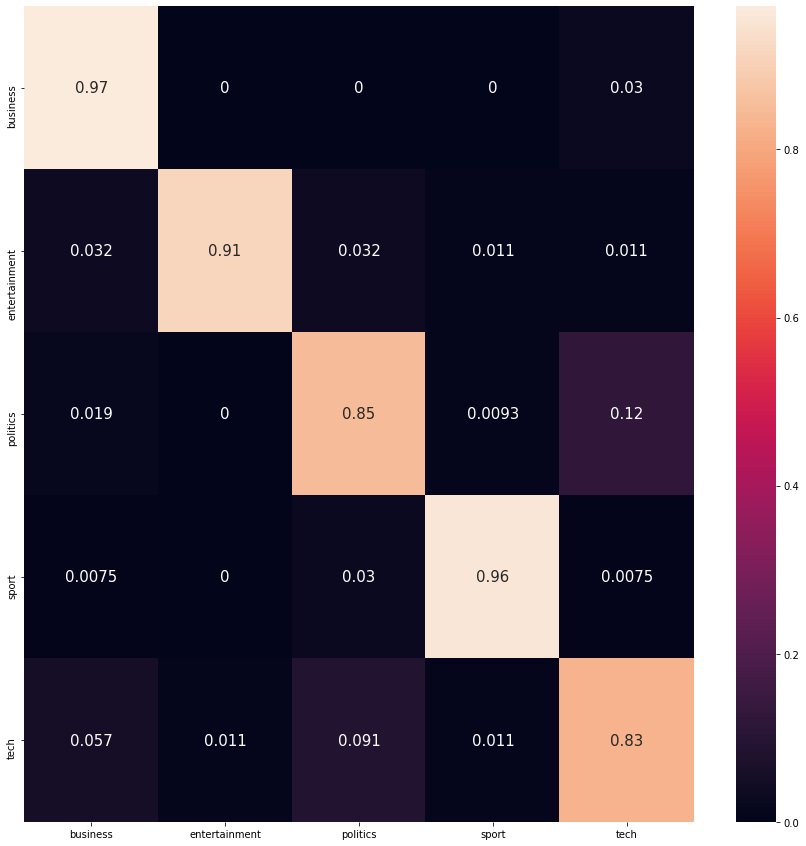

In [ ]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['business', 'entertainment', 'politics', 'sport', 'tech'],columns = ['business', 'entertainment', 'politics', 'sport', 'tech'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

### Textos de ejemplo para testeo

In [ ]:
type = ['business', 'entertainment', 'politics', 'sport', 'tech']

In [ ]:
sequence = tokenizer.texts_to_sequences(['In a landmark lawsuit, US regulators have accused Facebook of buying up rivals in order to stifle competition.'])
test = pad_sequences(sequence, maxlen=max_len)
type[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'business'

In [ ]:
sequence = tokenizer.texts_to_sequences(['How could a no-deal Brexit affect Scotland?'])
test = pad_sequences(sequence, maxlen=max_len)
type[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'politics'

In [ ]:
sequence = tokenizer.texts_to_sequences(['Leo Messi has won a new trophy'])
test = pad_sequences(sequence, maxlen=max_len)
type[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'sport'

In [ ]:
sequence = tokenizer.texts_to_sequences(['The Last Of Us Part 2 has won game of the year at the 2020 Game Awards.'])
test = pad_sequences(sequence, maxlen=max_len)
type[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'sport'

### Textos usados en otros modelos

In [ ]:
sequence = tokenizer.texts_to_sequences(['How to be the president of the United States of America.'])
test = pad_sequences(sequence, maxlen=max_len)
type[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'business'

In [ ]:
sequence = tokenizer.texts_to_sequences(['The match was played in the field of Manchester United. Anthony Martial scored the lonely goal of the night'])
test = pad_sequences(sequence, maxlen=max_len)
type[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'sport'

In [ ]:
sequence = tokenizer.texts_to_sequences(['The TESLA actions have fluctuated in this period. They are not gonna be profitable'])
test = pad_sequences(sequence, maxlen=max_len)
type[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'business'

In [ ]:
sequence = tokenizer.texts_to_sequences(['The Simpsons are going to lose one character: Apu Nahasapeemapetilon'])
test = pad_sequences(sequence, maxlen=max_len)
type[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'entertainment'

In [ ]:
sequence = tokenizer.texts_to_sequences(['The new computer has been built based on a Raspberry pi 4'])
test = pad_sequences(sequence, maxlen=max_len)
type[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'tech'

In [ ]:
sequence = tokenizer.texts_to_sequences(['George Bush has landed a new attack on Syria'])
test = pad_sequences(sequence, maxlen=max_len)
type[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'entertainment'

In [ ]:
sequence = tokenizer.texts_to_sequences(['US has sent military reinforcements to win the war'])
test = pad_sequences(sequence, maxlen=max_len)
type[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'sport'

In [ ]:
sequence = tokenizer.texts_to_sequences(['Manchester United scored a precious goal aganist chelsea'])
test = pad_sequences(sequence, maxlen=max_len)
type[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'sport'

In [ ]:
sequence = tokenizer.texts_to_sequences(['The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.'])
test = pad_sequences(sequence, maxlen=max_len)
type[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'entertainment'